In [20]:
import numpy as np
import matplotlib.pyplot as plt
from galpy.potential import NFWPotential
from scipy.interpolate import interp1d
from scipy.integrate import simps
from matplotlib import gridspec
import seaborn

In [3]:
class Stream:

    '''
    These are the variables common to all streams.

    G - The gravitational constant
    nfwp - NFW potential for the host galaxy of the streams and subhalos
    nump - number of psi0 data points at which to calculate the different variables
    psi0 - the range of initial angles to the different points along the stream.
           psi0 = 0 occurs at the point of closest approach of the subhalo along the stream.
    '''

    nfwp= NFWPotential(normalize=1.,a=14./10.)
    G = 4.302e-3 #pc*M_sun^-1*(km/s)^2
    nump = 1000

    '''
    There are several functions which can be called on the stream.

    __init__ - initializes a stream with the parameters passe to it and calculates several important parameters

        Input parameters:
            mass (Solar masses) - mass of the subhalo
            rstream (pc) - radius of the circular orbit of the stream around the galaxy centre
            rsub (pc) - Radius of the subhalo
            impact - impact parameter of the subhalo
            subvel (km/s) - Velocity of the subhalo in coordinates specified by the stream 
            t (Myr) - Time elapsed since time of closest approach of the subhalo

        Calculated parameters:
            wperp (km/s) - Perpendicular component of the relative velocity to points in the stream
            wpar (km/s) - Parallel component of relative velocity 
            w (km/s) - Total magnitude of relative velocity between the subha and points in the stream

            dv (km/s) - Calcultes the initial kick to velocity as a function of angle. Not time dependent.
            psi (radians) - Calculates the new angles to stars after a time, t.
            rho - Calculates the density of the stream after a time, t.
            dx (dx[0] (pc), dx[2] (radians)) - Change to position of stars in the stream after a time, t.
            dxdot (km/s) - Change in velocity of stars in the stream after a time, t.
            
            gT (radians) - calculates a very commonly used angle in several functions
            gamma - 
    '''
    def __init__(self,mass,rstream,rsub,impact,subvel,t,psi0=[-20./180.*np.pi,20/180.*np.pi]):

        self.psi0 = np.linspace(psi0[0],psi0[1],self.nump)

        self.m = mass   
        self.r0 = rstream   
        self.rs = rsub  
        self.b = impact   
        self.wvec = subvel   
        self.t = t*1.02 # Myr*1.02(pc/(km/s)/Myr) - converts to time in units pc/(km/s)
        self.vy = self.nfwp.vcirc(self.r0/10000.)*168.2

        self.wperp = np.sqrt(subvel[0]**2 + subvel[2]**2)
        self.wpar = self.vy - subvel[1]
        self.w = np.sqrt(subvel[0]**2 + (self.vy - subvel[1])**2 + subvel[2]**2)

        self.gamma = self.calc_gamma()
        self.dv = self.calc_dv(self.psi0)            
        self.psi,self.rho = self.calc_psi_rho(self.psi0)
        self.dx = self.calc_dx(self.psi0) 
        self.dxdot = self.calc_dxdot(self.psi0) 

        
    def gT(self):
        angle = self.gamma*self.vy*self.t/self.r0
        return angle


    def calc_gamma(self):
        g = 3. + (self.r0/10000.)**2*168.2**2*self.nfwp.R2deriv(self.r0/10000.,0.)/self.vy**2.

        return np.sqrt(g)


    def calc_dv(self,psi0):
        M = self.m
        r0 = self.r0
        wperp = self.wperp
        wpar= self.wpar
        w = self.w
        wvec = self.wvec
        b = self.b
        rs = self.rs
        G = self.G
        nump = len(psi0)
        
        deltav = np.zeros([3,nump])
        deltav[0] = 2.*G*M/r0/wperp**2/w*(b*w**2*wvec[2]/wperp-psi0*wpar*wvec[0])/(psi0**2+(b**2+rs**2/r0**2)*w**2/wperp**2)
        deltav[1] = -2.*G*M*psi0/r0/w/(psi0**2+(b**2+rs**2/r0**2)*w**2/wperp**2)
        deltav[2] = -2.*G*M/r0/wperp**2/w*(b*w**2*wvec[0]/wperp+psi0*wpar*wvec[2])/(psi0**2+(b**2+rs**2/r0**2)*w**2/wperp**2)

        return deltav
        

    def calc_psi_rho(self,psi0):
        gam = self.calc_gamma()
        gT = self.gT()

        t = self.t
        r0 = self.r0
        vy = self.vy
        wperp  = self.wperp
        wpar = self.wpar
        wvec = self.wvec
        w = self.w
        b = self.b
        rs = self.rs

        tau = w*r0**2/2./self.G/self.m
        
        f = (4.-gam**2)/gam**2*t/tau - 4.*np.sin(gT)/gam**3*r0/vy/tau+2.*(1.-np.cos(gT))/gam**2*wperp*wvec[0]/wpar**2*r0/vy/tau
        g = 2.*(1-np.cos(gT))*b*w**2*wvec[2]*r0/(gam**2*wperp**3*vy*tau)
        B2 = (b**2+rs**2/r0**2)*w**2/wperp**2
        
        psi = psi0+(f*psi0-g)/(psi0**2+B2)
        rho = (1.+(f*B2-f*psi0**2+2.*g*psi0)/(psi0**2+B2)**2)**(-1)

        return psi,rho

    def calc_dx(self,psi0):
        r0 = self.r0
        vy = self.vy
        dv = self.calc_dv(psi0)
        gam = self.calc_gamma()

        gT = self.gT()
        nump = len(psi0)
        
        deltax = np.zeros([3,nump])
        deltax[0] = 2.*r0*dv[1]/vy*(1.-np.cos(gT))/gam**2+r0*dv[0]/vy*np.sin(gT)/self.gamma
        deltax[2] = dv[2]/vy*np.sin(vy*self.t/r0)
        
        return deltax

    def calc_dxdot(self,psi0):
        vy = self.vy
        dv = self.calc_dv(psi0)
        gamma = self.calc_gamma()
        gT = self.gT()
        nump = len(psi0)
        
        deltaxdot = np.zeros([3,nump])
        deltaxdot[0] = 2.*dv[1]/gamma*np.sin(gT)+dv[0]*np.cos(gT)
        deltaxdot[1] = -dv[1]*(2.-gamma**2)/gamma**2+2.*dv[1]*np.cos(gT)/gamma**2-dv[0]*np.sin(gT)/gamma
        deltaxdot[2] = dv[2]*np.cos(vy*self.t/self.r0)

        return deltaxdot

In [ ]:
class MessyStream:

    '''
    These are the variables common to all streams.

    G - The gravitational constant
    nfwp - NFW potential for the host galaxy of the streams and subhalos
    nump - number of psi0 data points at which to calculate the different variables
    psi0 - the range of initial angles to the different points along the stream.
           psi0 = 0 occurs at the point of closest approach of the subhalo along the stream.
    '''

    nfwp= NFWPotential(normalize=1.,a=14./10.)
    G = 4.302e-3 #pc*M_sun^-1*(km/s)^2

    '''
    There are several functions which can be called on the stream.

    __init__ - initializes a stream with the parameters passe to it and calculates several important parameters

        Input parameters:
            mass (Solar masses) - mass of the subhalo
            rstream (pc) - radius of the circular orbit of the stream around the galaxy centre
            rsub (pc) - Radius of the subhalo
            impact - impact parameter of the subhalo
            subvel (km/s) - Velocity of the subhalo in coordinates specified by the stream 
            t (Myr) - Time elapsed since time of closest approach of the subhalo

        Calculated parameters:
            wperp (km/s) - Perpendicular component of the relative velocity to points in the stream
            wpar (km/s) - Parallel component of relative velocity 
            w (km/s) - Total magnitude of relative velocity between the subha and points in the stream

            dv (km/s) - Calcultes the initial kick to velocity as a function of angle. Not time dependent.
            psi (radians) - Calculates the new angles to stars after a time, t.
            rho - Calculates the density of the stream after a time, t.
            dx (dx[0] (pc), dx[2] (radians)) - Change to position of stars in the stream after a time, t.
            dxdot (km/s) - Change in velocity of stars in the stream after a time, t.
            
            gT (radians) - calculates a very commonly used angle in several functions
            gamma - 
    '''
    def __init__(self,mass,rstream,rsub,impact,subvel,t,nstars,psi0=[-20./180.*np.pi,20/180.*np.pi]):

        self.psi0 = np.linspace(psi0[0],psi0[1],self.nump)

        self.m = mass   
        self.r0 = rstream   
        self.rs = rsub  
        self.b = impact   
        self.wvec = subvel   
        self.t = t*1.02 # Myr*1.02(pc/(km/s)/Myr) - converts to time in units pc/(km/s)
        self.vy = self.nfwp.vcirc(self.r0/10000.)*168.2

        self.wperp = np.sqrt(subvel[0]**2 + subvel[2]**2)
        self.wpar = self.vy - subvel[1]
        self.w = np.sqrt(subvel[0]**2 + (self.vy - subvel[1])**2 + subvel[2]**2)

        self.gamma = self.calc_gamma()
        self.dv = self.calc_dv(self.psi0)            
        self.psi,self.rho = self.calc_psi_rho(self.psi0)
        self.dx = self.calc_dx(self.psi0) 
        self.dxdot = self.calc_dxdot(self.psi0) 

        
    def gT(self):
        angle = self.gamma*self.vy*self.t/self.r0
        return angle


    def calc_gamma(self):
        g = 3. + (self.r0/10000.)**2*168.2**2*self.nfwp.R2deriv(self.r0/10000.,0.)/self.vy**2.

        return np.sqrt(g)


    def calc_dv(self,psi0):
        M = self.m
        r0 = self.r0
        wperp = self.wperp
        wpar= self.wpar
        w = self.w
        wvec = self.wvec
        b = self.b
        rs = self.rs
        G = self.G
        nump = len(psi0)
        
        deltav = np.zeros([3,nump])
        deltav[0] = 2.*G*M/r0/wperp**2/w*(b*w**2*wvec[2]/wperp-psi0*wpar*wvec[0])/(psi0**2+(b**2+rs**2/r0**2)*w**2/wperp**2)
        deltav[1] = -2.*G*M*psi0/r0/w/(psi0**2+(b**2+rs**2/r0**2)*w**2/wperp**2)
        deltav[2] = -2.*G*M/r0/wperp**2/w*(b*w**2*wvec[0]/wperp+psi0*wpar*wvec[2])/(psi0**2+(b**2+rs**2/r0**2)*w**2/wperp**2)

        return deltav
        

    def calc_psi_rho(self,psi0):
        gam = self.calc_gamma()
        gT = self.gT()

        t = self.t
        r0 = self.r0
        vy = self.vy
        wperp  = self.wperp
        wpar = self.wpar
        wvec = self.wvec
        w = self.w
        b = self.b
        rs = self.rs

        tau = w*r0**2/2./self.G/self.m
        
        f = (4.-gam**2)/gam**2*t/tau - 4.*np.sin(gT)/gam**3*r0/vy/tau+2.*(1.-np.cos(gT))/gam**2*wperp*wvec[0]/wpar**2*r0/vy/tau
        g = 2.*(1-np.cos(gT))*b*w**2*wvec[2]*r0/(gam**2*wperp**3*vy*tau)
        B2 = (b**2+rs**2/r0**2)*w**2/wperp**2
        
        psi = psi0+(f*psi0-g)/(psi0**2+B2)
        rho = (1.+(f*B2-f*psi0**2+2.*g*psi0)/(psi0**2+B2)**2)**(-1)

        return psi,rho

    def calc_dx(self,psi0):
        r0 = self.r0
        vy = self.vy
        dv = self.calc_dv(psi0)
        gam = self.calc_gamma()

        gT = self.gT()
        nump = len(psi0)
        
        deltax = np.zeros([3,nump])
        deltax[0] = 2.*r0*dv[1]/vy*(1.-np.cos(gT))/gam**2+r0*dv[0]/vy*np.sin(gT)/self.gamma
        deltax[2] = dv[2]/vy*np.sin(vy*self.t/r0)
        
        return deltax

    def calc_dxdot(self,psi0):
        vy = self.vy
        dv = self.calc_dv(psi0)
        gamma = self.calc_gamma()
        gT = self.gT()
        nump = len(psi0)
        
        deltaxdot = np.zeros([3,nump])
        deltaxdot[0] = 2.*dv[1]/gamma*np.sin(gT)+dv[0]*np.cos(gT)
        deltaxdot[1] = -dv[1]*(2.-gamma**2)/gamma**2+2.*dv[1]*np.cos(gT)/gamma**2-dv[0]*np.sin(gT)/gamma
        deltaxdot[2] = dv[2]*np.cos(vy*self.t/self.r0)

        return deltaxdot

In [30]:
class MessyStreamData:
    
    nfwp= NFWPotential(normalize=1.,a=14./10.)
    G = 4.302e-3 #pc*M_sun^-1*(km/s)^2

    def __init__(self,mass,rstream,rsub,impact,subvel,t,nstars,sigmav,std,psi0=[-20./180.*np.pi,20/180.*np.pi]):
        self.nump = nstars
        self.psi0 = np.sort(np.random.uniform(psi0[0],psi0[1],size=nstars))
        
        self.vysigma = sigmav
        self.dxstd = std[0]
        self.dxdotstd = std[1]

        self.m = mass
        self.r0 = rstream
        self.rs = rsub
        self.b = impact
        self.wvec = subvel
        self.t = t*1.0227 # Myr*1.02(pc/(km/s)/Myr) - converts to time in units pc/(km/s)
        self.vy = self.nfwp.vcirc(10.)*168.2
        self.noisyvy = self.vy + np.random.normal(scale=self.vysigma,size=nstars)
        
        self.wperp = np.sqrt(subvel[0]**2 + subvel[2]**2)
        self.wpar = self.noisyvy - subvel[1]
        self.w = np.sqrt(self.wperp**2 + self.wpar**2)
        
        self.gamma = self.calc_gamma()
        self.dv = self.calc_dv(self.psi0)
        self.psi,self.rho = self.calc_psi_rho(self.psi0)
        self.dx = self.calc_dx(self.psi0,self.dxstd)
        self.dxdot = self.calc_dxdot(self.psi0,self.dxdotstd)
    
        sorteddata = np.array([(self.psi[i],self.dx[0,i],self.dx[1,i],self.dx[2,i],self.dxdot[0,i],self.dxdot[1,i],self.dxdot[2,i]) for i in np.argsort(self.psi)])
        self.data = [sorteddata[:,0],np.transpose(sorteddata[:,1:4]),np.transpose(sorteddata[:,4:7])]
    
    def gT(self):
        angle = self.gamma*self.noisyvy*self.t/self.r0
        return angle


    def calc_gamma(self):
        g = 3. + (self.r0/10000.)**2*168.2**2*self.nfwp.R2deriv(self.r0/10000.,0.)/self.noisyvy**2.
        
        return np.sqrt(g)
    
    
    def calc_dv(self,psi0):
        M = self.m
        r0 = self.r0
        wperp = self.wperp
        wpar= self.wpar
        w = self.w
        wvec = self.wvec
        b = self.b
        rs = self.rs
        G = self.G
        nump = len(psi0)
        
        deltav = np.zeros([3,nump])
        deltav[0] = 2.*G*M/r0/wperp**2/w*(b*w**2*wvec[2]/wperp-psi0*wpar*wvec[0])/(psi0**2+(b**2+rs**2/r0**2)*w**2/wperp**2)
        deltav[1] = -2.*G*M*psi0/r0/w/(psi0**2+(b**2+rs**2/r0**2)*w**2/wperp**2)
        deltav[2] = -2.*G*M/r0/wperp**2/w*(b*w**2*wvec[0]/wperp+psi0*wpar*wvec[2])/(psi0**2+(b**2+rs**2/r0**2)*w**2/wperp**2)
        
        return deltav


    def calc_psi_rho(self,psi0):
        gam = self.calc_gamma()
        gT = self.gT()
        
        t = self.t
        r0 = self.r0
        vy = self.noisyvy
        wperp  = self.wperp
        wpar = self.wpar
        wvec = self.wvec
        w = self.w
        b = self.b
        rs = self.rs
        
        tau = w*r0**2/2./self.G/self.m
        
        f = (4.-gam**2)/gam**2*t/tau - 4.*np.sin(gT)/gam**3*r0/vy/tau+2.*(1.-np.cos(gT))/gam**2*wpar*wvec[0]/wperp**2*r0/vy/tau
        g = 2.*(1-np.cos(gT))*b*w**2*wvec[2]*r0/(gam**2*wperp**3*vy*tau)
        B2 = (b**2+rs**2/r0**2)*w**2/wperp**2
        
        psi = psi0+(f*psi0-g)/(psi0**2+B2)
        rho = (1.+(f*B2-f*psi0**2+2.*g*psi0)/(psi0**2+B2)**2)**(-1)
        
        return psi,rho

    
    def calc_dx(self,psi0,std):
        r0 = self.r0
        vy = self.noisyvy
        dv = self.calc_dv(psi0)
        gam = self.calc_gamma()
        
        gT = self.gT()
        nump = len(psi0)
        
        noisedx = np.zeros([3,nump])
        noisedx[0] = np.random.normal(scale=std[0],size=nump)
        noisedx[2] = np.random.normal(scale=std[2],size=nump)

        deltax = np.zeros([3,nump])
        deltax[0] = 2.*r0*dv[1]/vy*(1.-np.cos(gT))/gam**2+r0*dv[0]/vy*np.sin(gT)/self.gamma + noisedx[0]
        deltax[2] = dv[2]/vy*np.sin(vy*self.t/r0) + noisedx[2]
        
        return deltax

    def calc_dxdot(self,psi0,std):
        vy = self.noisyvy
        dv = self.calc_dv(psi0)
        gamma = self.calc_gamma()
        gT = self.gT()
        nump = len(psi0)
        
        noisedxdot = np.zeros([3,nump])
    
        for i in range(3):
            noisedxdot[i] = np.random.normal(scale=std[i],size=nump)
        
        deltaxdot = np.zeros([3,nump])
        deltaxdot[0] = 2.*dv[1]/gamma*np.sin(gT)+dv[0]*np.cos(gT) + noisedxdot[0]
        deltaxdot[1] = -dv[1]*(2.-gamma**2)/gamma**2+2.*dv[1]*np.cos(gT)/gamma**2-dv[0]*np.sin(gT)/gamma + noisedxdot[1]
        deltaxdot[2] = dv[2]*np.cos(vy*self.t/self.r0) + noisedxdot[2]
        
        return deltaxdot

In [4]:
def GenData(stream,nstars,std):

    dxstd = std[0]
    dxdotstd = std[1]
    
    #generate random number between (0,1] with uniform distribution
    psi0 = np.random.uniform(stream.psi0[int(stream.nump*0.1)],stream.psi0[-int(stream.nump*0.1+1)],size=nstars)
    
    psi0 = np.sort(psi0)
    
    #Calculate stream parameters with the new psi0               
    datapsi, datarho = stream.calc_psi_rho(psi0)     
    datadx = stream.calc_dx(psi0)      
    datadxdot = stream.calc_dxdot(psi0) 
    
    #add noise to the variables
    noisedx = np.zeros([3,nstars])
    noisedxdot = np.zeros([3,nstars])

    for i in range(3):
        noisedxdot[i] = np.random.normal(scale=dxdotstd[i],size=nstars)
        if i != 1:
            noisedx[i] = np.random.normal(scale=dxstd[i],size=nstars)
            
    datadx = datadx + noisedx
    datadxdot = datadxdot + noisedxdot

    return datapsi,datadx,datadxdot

In [5]:
def Erkalplot(stream,data):
    
    psidata = data[0]
    dxdata = data[1]
    dxdotdata = data[2]
    
    dx = stream.dx
    dxdot = stream.dxdot
    psi = stream.psi*180./np.pi
    psi0 = stream.psi0*180./np.pi
    dv = stream.dv
    rho = stream.rho/simps(stream.rho,psi)*(psi[-1]-psi[0])/(np.max(psidata)-np.min(psidata))
    
    max_yticks = 3
    yloc = plt.MaxNLocator(max_yticks)

    f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, sharex='col', sharey='row')
    ax1.plot(psidata,dxdata[0]/1000.,'.',c='grey')
    ax1.plot(psi,dx[0]/1000.,'k-')
    ax1.set_ylabel(r'$\Delta x\,\,(kpc)$')
    ax1.yaxis.set_major_locator(yloc)
    
    ax2.plot(psidata,dxdata[2]*180./np.pi,'.',c='grey')
    ax2.plot(psi,dx[2]*180./np.pi,'k-')
    ax2.set_ylabel(r'$\delta_z\,\,(^\circ)$')
    ax2.yaxis.set_major_locator(yloc)
    
    ax3.plot(psidata,dxdotdata[0],'.',c='grey')
    ax3.plot(psi,dxdot[0],'k-')
    ax3.set_ylabel(r'$\Delta v_x$')
    ax3.yaxis.set_major_locator(yloc)
    
    ax4.plot(psidata,dxdotdata[1],'.',c='grey')
    ax4.plot(psi,dxdot[1],'k-')
    ax4.set_ylabel(r'$\Delta v_y$')
    ax4.yaxis.set_major_locator(yloc)
    
    ax5.plot(psidata,dxdotdata[2],'.',c='grey')
    ax5.plot(psi,dxdot[2],'k-')
    ax5.set_ylabel(r'$\Delta v_z$')
    ax5.yaxis.set_major_locator(yloc)
    
    ax6.plot(psi,rho,'k-')
    ax6.hist(psidata,bins=100,normed=True,align='mid',histtype='step')
    ax6.set_ylabel(r'$\rho$')
    ax6.set_xlabel(r'$\Psi (^\circ)$')
    ax6.yaxis.set_major_locator(yloc)
    
    mass = '%.0e' % stream.m
    time = '%04.0f' % (stream.t/1.02)
    b = '%f' % stream.b
    rs = '%04.0f' % stream.rs
    filename = 'M'+mass+'_Rs'+rs+'_b'+b+'_t'+time+'.png'
    f.savefig(filename)
    print('Saving to: ', filename)

In [37]:
if __name__ == "__main__":

    mass = 1.e8
    rstream = 9800.
    rsub = 625.
    impact = 0.
    subvel = [150.,0.,0.]
    nstars = 1000
    sigmav = 20.
    time = 450.
    std = [[0.,0.,0.],[0.,0.,0.]]

    stream1 = Stream(mass,rstream,rsub,impact,subvel,time)
    stream2 = Stream(1.e7,rstream,250.,impact,subvel,time)
    
    streams = [stream1,stream2]

In [38]:
data1 = MessyStreamData(mass,rstream,rsub,impact,subvel,time,nstars,sigmav,std,psi0=[-20./180.*np.pi,20/180.*np.pi])

In [39]:
f = interp1d(stream1.psi0,stream1.psi)
modelpsi = f(data1.psi0)

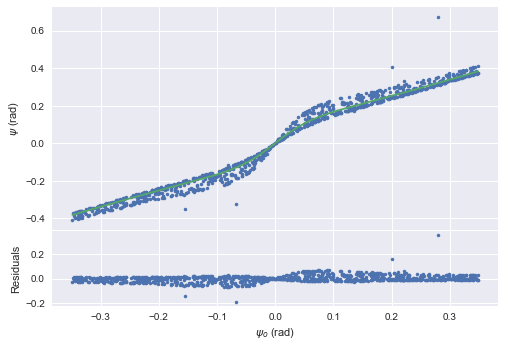

In [40]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax0.plot(data1.psi0,data1.psi,'.') 
ax0.plot(data1.psi0,modelpsi,'-')
ax1.set_xlabel(r'$\psi_o$ (rad)')
ax1.set_ylabel(r'Residuals')
ax0.set_ylabel(r'$\psi$ (rad)')
ax1.plot(data1.psi0,data1.psi-modelpsi,'.')
fig.subplots_adjust(hspace=0.01)

plt.show()

In [36]:
psiSpread = np.std(data1.psi-modelpsi)
print(psiSpread)

0.003520520864


Saving to:  M1e+08_Rs0773_b0.000160_t0476.png
Saving to:  M1e+07_Rs0250_b0.000160_t0476.png


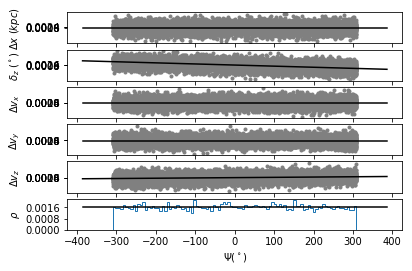

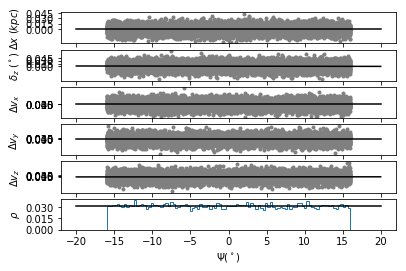

In [8]:
    for stream in streams:

        psidata,dxdata,dxdotdata = GenData(stream,10000,[dxstd,dxdotstd])
        psidata = psidata*180./np.pi

        data = [psidata,dxdata,dxdotdata]

        Erkalplot(stream,data)

    plt.show()